In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 490

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ImageFolder('/content/fer_ckplus', data_transforms['train'])
val_data = ImageFolder('/content/fer_ckplus', data_transforms['val'])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.targets,
    stratify=train_data.targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
from torchvision.ops.misc import Conv2dNormActivation, Permute
from torchvision.ops.stochastic_depth import StochasticDepth
from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
import copy
import math
from torchvision.models.mobilenetv3 import InvertedResidualConfig, InvertedResidual
from functools import partial

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/mobilenetv3.html
class MobileNetV3(nn.Module):
    def __init__(
        self,
        inverted_residual_setting: List[InvertedResidualConfig],
        last_channel: int,
        num_classes: int = 7,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
        **kwargs: Any,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (
            isinstance(inverted_residual_setting, Sequence)
            and all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])
        ):
            raise TypeError("The inverted_residual_setting should be List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(
            Conv2dNormActivation(
                1,
                firstconv_output_channels,
                kernel_size=3,
                stride=2,
                norm_layer=norm_layer,
                activation_layer=nn.Hardswish,
            )
        )

        # building inverted residual blocks
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = 6 * lastconv_input_channels
        layers.append(
            Conv2dNormActivation(
                lastconv_input_channels,
                lastconv_output_channels,
                kernel_size=1,
                norm_layer=norm_layer,
                activation_layer=nn.Hardswish,
            )
        )

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(lastconv_output_channels, last_channel),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=dropout, inplace=True),
            nn.Linear(last_channel, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [ ]:
reduce_divider = 1
dilation = 1
width_mult = 1.0

bneck_conf = partial(InvertedResidualConfig, width_mult=width_mult)
adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_mult=width_mult)
inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, False, "RE", 1, 1),
            bneck_conf(16, 3, 64, 24, False, "RE", 2, 1),  # C1
            bneck_conf(24, 3, 72, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 72, 40, True, "RE", 2, 1),  # C2
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 3, 240, 80, False, "HS", 2, 1),  # C3
            bneck_conf(80, 3, 200, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 480, 112, True, "HS", 1, 1),
            bneck_conf(112, 3, 672, 112, True, "HS", 1, 1),
            bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
        ]
last_channel = adjust_channels(1280 // reduce_divider)  # C5

model = MobileNetV3(inverted_residual_setting, last_channel)

In [ ]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 90
grad_clip = 0.2
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             144
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         Hardswish-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             144
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             256
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  InvertedResidual-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]           1,024
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]             576
      BatchNorm2d-14           [-1, 64,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00004, train_loss: 1.8102, val_loss: 1.8224, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00005, train_loss: 1.7559, val_loss: 1.7531, val_acc: 0.1883


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00007, train_loss: 1.7048, val_loss: 1.6553, val_acc: 0.2551


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00009, train_loss: 1.6444, val_loss: 1.6502, val_acc: 0.2426


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00012, train_loss: 1.5845, val_loss: 1.5711, val_acc: 0.3023


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00015, train_loss: 1.5249, val_loss: 1.4955, val_acc: 0.3530


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00019, train_loss: 1.4658, val_loss: 1.4234, val_acc: 0.4051


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00023, train_loss: 1.4232, val_loss: 1.3666, val_acc: 0.3820


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00028, train_loss: 1.3755, val_loss: 1.3365, val_acc: 0.3986


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00033, train_loss: 1.3285, val_loss: 1.3738, val_acc: 0.3957


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00038, train_loss: 1.2941, val_loss: 1.2907, val_acc: 0.4430


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00044, train_loss: 1.2569, val_loss: 1.2713, val_acc: 0.4345


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00049, train_loss: 1.2268, val_loss: 1.2576, val_acc: 0.4730


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00055, train_loss: 1.1928, val_loss: 1.2126, val_acc: 0.4898


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00060, train_loss: 1.1684, val_loss: 1.2839, val_acc: 0.4244


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00066, train_loss: 1.1432, val_loss: 1.2159, val_acc: 0.4949
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00071, train_loss: 1.1200, val_loss: 1.1797, val_acc: 0.4750


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00076, train_loss: 1.0990, val_loss: 1.1432, val_acc: 0.5206


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00081, train_loss: 1.0857, val_loss: 1.1154, val_acc: 0.5576


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00085, train_loss: 1.0659, val_loss: 1.1499, val_acc: 0.4766


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00089, train_loss: 1.0605, val_loss: 1.0874, val_acc: 0.5219


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00092, train_loss: 1.0373, val_loss: 1.0880, val_acc: 0.5078


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00095, train_loss: 1.0253, val_loss: 1.0774, val_acc: 0.5417


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00097, train_loss: 1.0101, val_loss: 1.0802, val_acc: 0.5520


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00099, train_loss: 0.9994, val_loss: 1.0494, val_acc: 0.5861


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00100, train_loss: 0.9882, val_loss: 1.0497, val_acc: 0.5808


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00100, train_loss: 0.9746, val_loss: 1.0618, val_acc: 0.5636


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00100, train_loss: 0.9675, val_loss: 1.0710, val_acc: 0.5471


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00100, train_loss: 0.9582, val_loss: 1.0033, val_acc: 0.5706


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00099, train_loss: 0.9438, val_loss: 1.0072, val_acc: 0.5695


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00099, train_loss: 0.9406, val_loss: 1.0849, val_acc: 0.5396


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00098, train_loss: 0.9278, val_loss: 1.0250, val_acc: 0.6082


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00098, train_loss: 0.9152, val_loss: 0.9820, val_acc: 0.5936


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00097, train_loss: 0.9117, val_loss: 0.9276, val_acc: 0.6124


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00096, train_loss: 0.8957, val_loss: 1.0321, val_acc: 0.5752


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00095, train_loss: 0.8830, val_loss: 1.0227, val_acc: 0.6038


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00094, train_loss: 0.8834, val_loss: 0.9893, val_acc: 0.6018


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00093, train_loss: 0.8758, val_loss: 0.9910, val_acc: 0.5973


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00091, train_loss: 0.8674, val_loss: 0.9868, val_acc: 0.5969


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00090, train_loss: 0.8527, val_loss: 0.9411, val_acc: 0.5720


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00088, train_loss: 0.8413, val_loss: 0.9665, val_acc: 0.6158
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00087, train_loss: 0.8391, val_loss: 1.0052, val_acc: 0.6098


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00085, train_loss: 0.8287, val_loss: 0.9733, val_acc: 0.6328
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00083, train_loss: 0.8242, val_loss: 0.9240, val_acc: 0.6245


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00081, train_loss: 0.8141, val_loss: 0.9543, val_acc: 0.5965


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00079, train_loss: 0.8023, val_loss: 0.8720, val_acc: 0.6520


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00077, train_loss: 0.7945, val_loss: 0.9030, val_acc: 0.6027


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00075, train_loss: 0.7843, val_loss: 0.8870, val_acc: 0.6658
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00073, train_loss: 0.7794, val_loss: 0.8827, val_acc: 0.6612


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00071, train_loss: 0.7698, val_loss: 0.9283, val_acc: 0.6254


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00068, train_loss: 0.7607, val_loss: 0.9146, val_acc: 0.6072


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00066, train_loss: 0.7590, val_loss: 0.8783, val_acc: 0.6582


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00064, train_loss: 0.7439, val_loss: 0.8255, val_acc: 0.6715


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00061, train_loss: 0.7386, val_loss: 0.9028, val_acc: 0.6409


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00059, train_loss: 0.7268, val_loss: 0.8790, val_acc: 0.6465


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00056, train_loss: 0.7202, val_loss: 0.9202, val_acc: 0.6413


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00054, train_loss: 0.7105, val_loss: 0.8841, val_acc: 0.6551


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00051, train_loss: 0.6970, val_loss: 0.9227, val_acc: 0.6271


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00049, train_loss: 0.6904, val_loss: 0.9061, val_acc: 0.6220


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00046, train_loss: 0.6866, val_loss: 0.8890, val_acc: 0.6455


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00044, train_loss: 0.6729, val_loss: 0.8601, val_acc: 0.6683


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00041, train_loss: 0.6597, val_loss: 0.9604, val_acc: 0.6111


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00039, train_loss: 0.6556, val_loss: 0.8481, val_acc: 0.6938
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00036, train_loss: 0.6398, val_loss: 0.8085, val_acc: 0.6968


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00034, train_loss: 0.6280, val_loss: 0.8553, val_acc: 0.6609


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00032, train_loss: 0.6256, val_loss: 0.8906, val_acc: 0.6921


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00029, train_loss: 0.6114, val_loss: 0.8447, val_acc: 0.6538


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00027, train_loss: 0.5976, val_loss: 0.8532, val_acc: 0.6690


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00025, train_loss: 0.5913, val_loss: 0.8318, val_acc: 0.6767


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00023, train_loss: 0.5881, val_loss: 0.8677, val_acc: 0.6668


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70], last_lr: 0.00021, train_loss: 0.5706, val_loss: 0.8577, val_acc: 0.6647


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71], last_lr: 0.00019, train_loss: 0.5657, val_loss: 0.8740, val_acc: 0.6880


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72], last_lr: 0.00017, train_loss: 0.5613, val_loss: 0.8319, val_acc: 0.6963


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73], last_lr: 0.00015, train_loss: 0.5485, val_loss: 0.8846, val_acc: 0.6923


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74], last_lr: 0.00013, train_loss: 0.5411, val_loss: 0.8419, val_acc: 0.6656


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75], last_lr: 0.00012, train_loss: 0.5308, val_loss: 0.9152, val_acc: 0.6742


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76], last_lr: 0.00010, train_loss: 0.5227, val_loss: 0.8934, val_acc: 0.6985
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77], last_lr: 0.00009, train_loss: 0.5216, val_loss: 0.8662, val_acc: 0.6801


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78], last_lr: 0.00007, train_loss: 0.5087, val_loss: 0.9049, val_acc: 0.6797


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79], last_lr: 0.00006, train_loss: 0.5038, val_loss: 0.9086, val_acc: 0.6867


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80], last_lr: 0.00005, train_loss: 0.5030, val_loss: 0.8616, val_acc: 0.7182
EarlyStopping counter: 2 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81], last_lr: 0.00004, train_loss: 0.4980, val_loss: 0.9257, val_acc: 0.6961


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82], last_lr: 0.00003, train_loss: 0.4992, val_loss: 0.8996, val_acc: 0.6987


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83], last_lr: 0.00002, train_loss: 0.4909, val_loss: 0.8737, val_acc: 0.7214
EarlyStopping counter: 3 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84], last_lr: 0.00002, train_loss: 0.4931, val_loss: 0.9410, val_acc: 0.6834


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85], last_lr: 0.00001, train_loss: 0.4814, val_loss: 0.8669, val_acc: 0.6991


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86], last_lr: 0.00001, train_loss: 0.4793, val_loss: 0.8846, val_acc: 0.6853


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87], last_lr: 0.00000, train_loss: 0.4852, val_loss: 0.9024, val_acc: 0.6830


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88], last_lr: 0.00000, train_loss: 0.4799, val_loss: 0.8949, val_acc: 0.6927


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89], last_lr: 0.00000, train_loss: 0.4812, val_loss: 0.8993, val_acc: 0.6998
Training complete in 74m 20s
Best val Acc: 0.721447


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.5286 , roc: 0.8899 , f1: 0.4797 , recall: 0.6603


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.4274 , roc: 0.8333 , f1: 0.387 , recall: 0.4453


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/mobilenet.pt')

In [ ]:
print(results)

{'acc': [0.14285714285714285, 0.1882620793311213, 0.25506633674535956, 0.24256400179310503, 0.30225250632654715, 0.3529646830451068, 0.4050796551595489, 0.3820488070658631, 0.39860816062367116, 0.3956982755455611, 0.4430348001714621, 0.43445215288415456, 0.4729712366094905, 0.48983344584544003, 0.42440975492319655, 0.4949028956501473, 0.4749694652909146, 0.5205930173599136, 0.557618670817589, 0.4765552566524519, 0.5218533605781495, 0.5078150116670165, 0.541727682778787, 0.551982705511988, 0.5860836411632052, 0.5808431597367187, 0.5636032092271581, 0.5470795508279381, 0.5706272807570302, 0.5695457364610609, 0.5396302360779066, 0.6082011290247632, 0.5936332997775761, 0.6124470780721013, 0.5751730861680822, 0.6037651492869637, 0.6018163388867126, 0.5973199554566555, 0.5968867381141392, 0.5720052689889155, 0.6158411775243771, 0.60981904499071, 0.63275822817672, 0.6245217084930894, 0.5965006102736851, 0.6520439787579063, 0.6026565797363529, 0.6657796370284726, 0.6612066509228705, 0.62543868

In [ ]:
results = {'acc': [0.14285714285714285, 0.1882620793311213, 0.25506633674535956, 0.24256400179310503, 0.30225250632654715, 0.3529646830451068, 0.4050796551595489, 0.3820488070658631, 0.39860816062367116, 0.3956982755455611, 0.4430348001714621, 0.43445215288415456, 0.4729712366094905, 0.48983344584544003, 0.42440975492319655, 0.4949028956501473, 0.4749694652909146, 0.5205930173599136, 0.557618670817589, 0.4765552566524519, 0.5218533605781495, 0.5078150116670165, 0.541727682778787, 0.551982705511988, 0.5860836411632052, 0.5808431597367187, 0.5636032092271581, 0.5470795508279381, 0.5706272807570302, 0.5695457364610609, 0.5396302360779066, 0.6082011290247632, 0.5936332997775761, 0.6124470780721013, 0.5751730861680822, 0.6037651492869637, 0.6018163388867126, 0.5973199554566555, 0.5968867381141392, 0.5720052689889155, 0.6158411775243771, 0.60981904499071, 0.63275822817672, 0.6245217084930894, 0.5965006102736851, 0.6520439787579063, 0.6026565797363529, 0.6657796370284726, 0.6612066509228705, 0.6254386856675078, 0.6071826673910435, 0.6581993153432479, 0.6714898811405181, 0.6408675873712308, 0.6464804538081113, 0.6413128744660969, 0.6551256300237256, 0.6270554092683247, 0.6220055323983769, 0.6455104305896168, 0.6682684088901313, 0.6111111102709053, 0.69375690081089, 0.6968434933966934, 0.6608713032243064, 0.6921068083610102, 0.6537684858086313, 0.6690248366981193, 0.6766719528710031, 0.6667861713821487, 0.6647236920411375, 0.6880190940769602, 0.6963023041338808, 0.6922515178692848, 0.6655816010806507, 0.6742035931420921, 0.6985302804036173, 0.6801302415384829, 0.6797436794920284, 0.6867002148183599, 0.7182136336444155, 0.6961458246791239, 0.6987432984796911, 0.7214466793789164, 0.6834052301331697, 0.699129258415664, 0.6852507285115286, 0.6830141234350304, 0.6926730436231735, 0.6997556591562288], 'f1': [0.06242879927090454, 0.1284615031857719, 0.22670577290489793, 0.24042154408906055, 0.27731917089849834, 0.35409958623250487, 0.40452582616899063, 0.39351968392793485, 0.38958067443076594, 0.3913293170610426, 0.4621897066534995, 0.4159510430558249, 0.4793872117589847, 0.4885730045338422, 0.4239740647281019, 0.501959435358778, 0.4801280588312434, 0.5225224908569527, 0.5444108116228661, 0.48238480369681236, 0.5252642159748026, 0.5143243085674466, 0.5553582746327611, 0.5737404883906886, 0.5921587367456169, 0.5915551462093621, 0.5696503094843649, 0.5542582688309834, 0.5940591046945204, 0.5794014954766445, 0.5576577537357859, 0.6251317078523485, 0.5804687035653654, 0.6276191123235145, 0.5928054345904944, 0.5695932210218932, 0.6097033000006282, 0.6084444066989889, 0.6090871149475067, 0.5818125202844184, 0.6330588828213723, 0.6122829415590949, 0.6159060320585273, 0.6337995898362853, 0.6159409241929746, 0.6673504094013749, 0.6210445614905157, 0.664952387402022, 0.6720936891909253, 0.6399438260269067, 0.6119662147038485, 0.6537079325842329, 0.682936687475579, 0.6525659390624446, 0.6481096044419473, 0.6554521195106038, 0.6626578343112975, 0.6355074649299027, 0.6085915694280042, 0.6458291021125443, 0.6725118522203049, 0.6199413235120119, 0.6939949327724028, 0.6902543377810282, 0.6755991971030159, 0.6991947817723617, 0.6541404107268265, 0.6659062136990105, 0.6825111765890489, 0.6751834392732821, 0.6572723495074921, 0.6812071472066143, 0.6994660575171416, 0.6746835052778671, 0.6714398625108907, 0.6787615112168476, 0.6960083595926504, 0.6725721005017602, 0.6819892866958198, 0.6775063386820328, 0.7109928597772271, 0.6968154623363935, 0.697717556072596, 0.7177209115568868, 0.6841977933081484, 0.6995239106127993, 0.6892332689052393, 0.6843517064622152, 0.6981743161149092, 0.7000746583923297], 'rec': [0.03994169096209913, 0.12767229337351288, 0.22895585289818846, 0.32938942960795214, 0.27782924308718526, 0.4249933693914433, 0.4395980832766925, 0.5343828042139791, 0.4600238748064835, 0.4796088343730139, 0.511353518427076, 0.4432457159178932, 0.496637370708258, 0.5370960154807835, 0.5806578567828529, 0.5435118990353459, 0.5320111805313105, 0.538833266049192, 0.574336067379648, 0.5536394171695936, 0.5473725388102221, 0.5942549897317418, 0.6228509081687773, 0.629944462416172, 0.6527103062232921, 0.6516085778143278, 0.5859966781139143, 0.6220263374209295, 0.6818745911314411, 0.6083622744688154, 0.63817217664256, 0.6551003146310422, 0.5892485797399937, 0.6838268640789649, 0.6504922045620231, 0.5752250192124057, 0.6581912748623289, 0.6273444575116611, 0.6514932163299275, 0.6275829303631563, 0.6746643571860963, 0.6201316774134896, 0.6070031851217951, 0.6799432673748254, 0.6880845607963294, 0.6953487343317851, 0.6605897799380305, 0.6831194658878753, 0.7015534267668553, 0.6692097818939997, 0.6242687348027466, 0.6656380064068882, 0.7113386111577793, 0.6883076721196745, 0.6566618623397112, 0.6896079493300685, 0.6786533734143123, 0.6507522562429932, 0.607392657755961, 0.6730708769994485, 0.6799392082657433, 0.6481200836752505, 0.7023790129913471, 0.6882290487400949, 0.703416850393079, 0.7119077808093361, 0.6560073736333034, 0.6667551334638796, 0.6994016978960985, 0.6927841311092017, 0.6567386656782205, 0.6774789034945119, 0.7066731967610284, 0.6642056609885822, 0.6846059265702122, 0.6885106123736994, 0.6999994831514326, 0.6687330355884813, 0.6898252432091437, 0.6737955869307184, 0.7100684802112477, 0.698959168044433, 0.7013647752135237, 0.7176638847191003, 0.687953337200349, 0.7004649297592173, 0.6980095430568658, 0.688138866146385, 0.7065341986450729, 0.7015424652629589], 'prec': [0.14285714285714285, 0.1882620793311213, 0.25506633674535956, 0.24256400179310503, 0.30225250632654715, 0.3529646830451068, 0.4050796551595489, 0.3820488070658631, 0.39860816062367116, 0.3956982755455611, 0.4430348001714621, 0.43445215288415456, 0.4729712366094905, 0.48983344584544003, 0.42440975492319655, 0.4949028956501473, 0.4749694652909146, 0.5205930173599136, 0.557618670817589, 0.4765552566524519, 0.5218533605781495, 0.5078150116670165, 0.541727682778787, 0.551982705511988, 0.5860836411632052, 0.5808431597367187, 0.5636032092271581, 0.5470795508279381, 0.5706272807570302, 0.5695457364610609, 0.5396302360779066, 0.6082011290247632, 0.5936332997775761, 0.6124470780721013, 0.5751730861680822, 0.6037651492869637, 0.6018163388867126, 0.5973199554566555, 0.5968867381141392, 0.5720052689889155, 0.6158411775243771, 0.60981904499071, 0.63275822817672, 0.6245217084930894, 0.5965006102736851, 0.6520439787579063, 0.6026565797363529, 0.6657796370284726, 0.6612066509228705, 0.6254386856675078, 0.6071826673910435, 0.6581993153432479, 0.6714898811405181, 0.6408675873712308, 0.6464804538081113, 0.6413128744660969, 0.6551256300237256, 0.6270554092683247, 0.6220055323983769, 0.6455104305896168, 0.6682684088901313, 0.6111111102709053, 0.69375690081089, 0.6968434933966934, 0.6608713032243064, 0.6921068083610102, 0.6537684858086313, 0.6690248366981193, 0.6766719528710031, 0.6667861713821487, 0.6647236920411375, 0.6880190940769602, 0.6963023041338808, 0.6922515178692848, 0.6655816010806507, 0.6742035931420921, 0.6985302804036173, 0.6801302415384829, 0.6797436794920284, 0.6867002148183599, 0.7182136336444155, 0.6961458246791239, 0.6987432984796911, 0.7214466793789164, 0.6834052301331697, 0.699129258415664, 0.6852507285115286, 0.6830141234350304, 0.6926730436231735, 0.6997556591562288], 'roc': [0.5561984368513233, 0.6001098548272955, 0.6777117663678063, 0.6861588185544341, 0.7178481149639333, 0.7474281260824481, 0.7758962075648085, 0.7926554191253619, 0.8061471823789718, 0.813316633081725, 0.8241355876524414, 0.8236967695564624, 0.8267215892123845, 0.8418828711164298, 0.8435369725651991, 0.852845056743884, 0.853816071165126, 0.86207186405645, 0.8713792983798826, 0.8681065893208675, 0.8749111952861787, 0.8780853653867885, 0.87875505287378, 0.8790133176257023, 0.8851118824164922, 0.8842921175746217, 0.8829498995528381, 0.885327322719175, 0.8952895251032812, 0.8926869304408876, 0.8808708676955718, 0.8927613073777741, 0.8926325848757404, 0.9060129842157976, 0.891233237789546, 0.8926463151894141, 0.8996776039674133, 0.89629037533867, 0.8973581090892199, 0.907344008360441, 0.9040164406909691, 0.8926916218414792, 0.8979703398851999, 0.9090199275731868, 0.9115330651254167, 0.9149990390809154, 0.9125740259411058, 0.9179649085668202, 0.9203091385237657, 0.9143470662487674, 0.9083997968935044, 0.9231766919060129, 0.9247118340784867, 0.915587050787772, 0.9177672678458387, 0.9136976494848922, 0.9191378364996299, 0.9154621009179795, 0.917183686623564, 0.9253832304230732, 0.9202210284106621, 0.9097653041290737, 0.9211859280933925, 0.9331435047027734, 0.9237772516288768, 0.9237186854780501, 0.9270126130189935, 0.9308270397030205, 0.9291099313903652, 0.927947285573409, 0.9243662886989682, 0.9260954010410652, 0.9334081470122244, 0.9270834357393263, 0.9286069086759332, 0.9240899597963229, 0.9280929982267514, 0.9286892964139383, 0.9228099204201644, 0.9294109931589951, 0.9324567212606297, 0.9245591565770334, 0.9257732771185657, 0.9254108283130356, 0.9195411937629431, 0.9324341856562197, 0.9282436004745472, 0.9282566950064103, 0.9251292063681245, 0.9248889608631854]}

In [ ]:
criterion = nn.CrossEntropyLoss()
model = MobileNetV3(inverted_residual_setting, last_channel)
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/mobilenet.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.7041 , roc: 0.949 , f1: 0.7035 , recall: 0.7448


In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

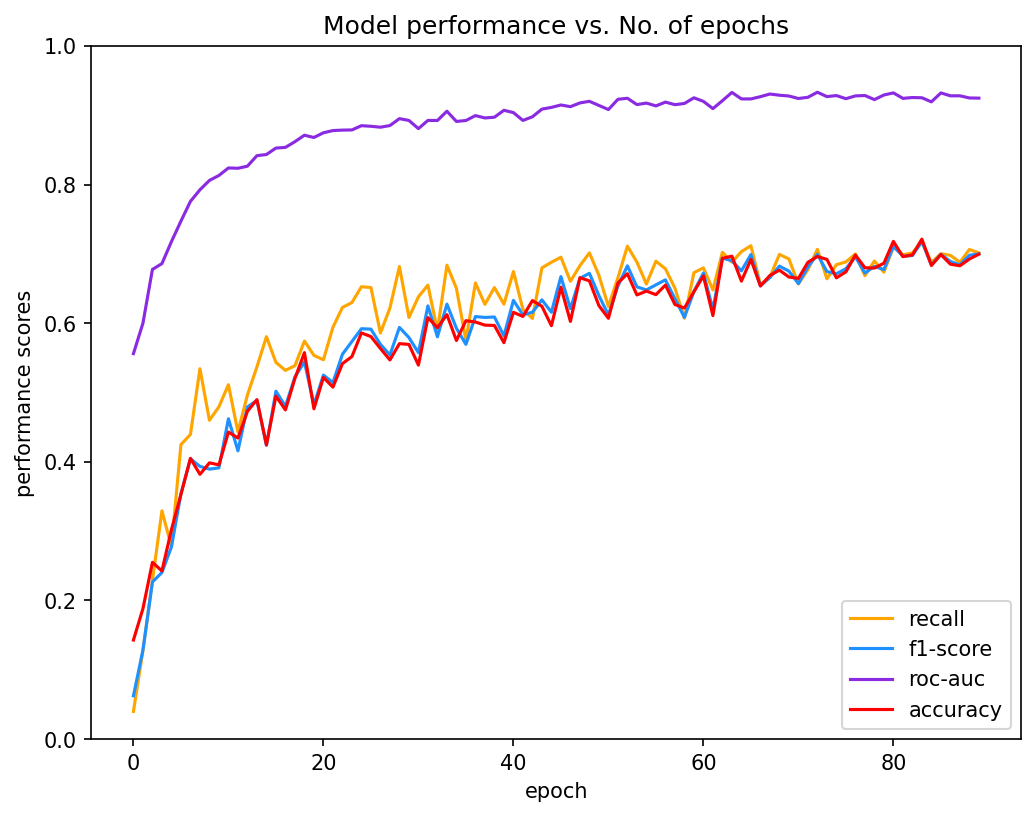

In [ ]:
plot_scores(results)